https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [1]:
import numpy as np
import typing
from typing import Any, Tuple
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import tensorflow_text

In [3]:
import einops

In [4]:
use_builtins = True
punctuation = '.?!,'
acceptable_chars = punctuation + ' abcdefghijklmnopqrstuvwxyzабвгґдеєжзиіїйклмнопрстуфхцчшщьюя'
acceptable_chars = tensorflow_text.normalize_utf8(acceptable_chars, 'NFKD')

Metal device set to: Apple M1 Pro


2022-10-12 20:31:01.260880: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-12 20:31:01.261463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def load_data(path):
    text = open(path, 'r', encoding='utf-8').read()

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    target = np.array([inp.lower() for targ, inp, _ in pairs])
    context = np.array([targ.lower() for targ, inp, _ in pairs])

    return target, context

In [6]:
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tensorflow_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^' + acceptable_chars + ']', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[' + punctuation + ']', r' \0 ')
    # After removing punctuation, double spaces will be left
    # Double spaces create empty tokens later on causing the most common token to be an empty string
    text = tf.strings.regex_replace(text, ' +', ' ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [32]:
class ShapeChecker():
    def __init__(self):
        # Keep a cache of every axis-name seen
        self.shapes = {}

    def __call__(self, tensor, names, broadcast=False):
        if not tf.executing_eagerly():
            return

        parsed = einops.parse_shape(tensor, names)

        for name, new_dim in parsed.items():
            old_dim = self.shapes.get(name, None)

            if (broadcast and new_dim == 1):
                continue

            if old_dim is None:
                # If the axis name is new, add its length to the cache.
                self.shapes[name] = new_dim
                continue

            if new_dim != old_dim:
                raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                                 f"    found: {new_dim}\n"
                                 f"    expected: {old_dim}\n")

In [8]:
# get raw data
path_to_data = 'ukr-eng/ukr.txt'
target_raw, context_raw = load_data(path_to_data)

In [13]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [14]:
# text vectorization
max_vocab_size = 5000

# input_text_processor creates token ID vectors
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [15]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

2022-10-12 20:31:36.260417: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-12 20:31:36.298807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


['', '[UNK]', '[START]', '[END]', '.', 'tom', 'i', 'you', '?', 'to']

In [16]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

2022-10-12 20:31:38.055580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


['', '[UNK]', '[START]', '[END]', '.', ',', 'я', 'том', 'не', '?']

In [18]:
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b"everyone's going." b'you would never do that.'
 b'have you heard the news?' b"tom's speech was too long."
 b'write to me if you need help.'], shape=(5,), dtype=string)

tf.Tensor(
[b'\xd1\x96\xd0\xb4\xd1\x83\xd1\x82\xd1\x8c \xd1\x83\xd1\x81\xd1\x96.'
 b'\xd1\x82\xd0\xb8 \xd0\xb1 \xd0\xbd\xd1\x96\xd0\xba\xd0\xbe\xd0\xbb\xd0\xb8 \xd1\x86\xd1\x8c\xd0\xbe\xd0\xb3\xd0\xbe \xd0\xbd\xd0\xb5 \xd0\xb7\xd1\x80\xd0\xbe\xd0\xb1\xd0\xb8\xd0\xb2.'
 b'\xd1\x82\xd0\xb8 \xd1\x87\xd1\x83\xd0\xb2 \xd0\xbd\xd0\xbe\xd0\xb2\xd0\xb8\xd0\xbd\xd0\xb8?'
 b'\xd0\xbf\xd1\x80\xd0\xbe\xd0\xbc\xd0\xbe\xd0\xb2\xd0\xb0 \xd1\x82\xd0\xbe\xd0\xbc\xd0\xb0 \xd0\xb1\xd1\x83\xd0\xbb\xd0\xb0 \xd0\xb7\xd0\xb0\xd0\xb4\xd0\xbe\xd0\xb2\xd0\xb3\xd0\xb0.'
 b'\xd0\xbd\xd0\xb0\xd0\xbf\xd0\xb8\xd1\x88\xd1\x96\xd1\x82\xd1\x8c \xd0\xbc\xd0\xb5\xd0\xbd\xd1\x96, \xd1\x8f\xd0\xba\xd1\x89\xd0\xbe \xd0\xbf\xd0\xbe\xd1\x82\xd1\x80\xd1\x96\xd0\xb1\xd0\xbd\xd0\xb0 \xd0\xb4\xd0\xbe\xd0\xbf\xd0\xbe\xd0\xbc\xd0\xbe\xd0\xb3\xd0\xb0.']

In [19]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 1174, 55, 4, 3], [2, 7, 74, 102, 14, 13, 4, 3],
 [2, 16, 7, 233, 10, 548, 8, 3]]>

In [20]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] everyones going . [END]'

Text(0.5, 1.0, 'Mask')

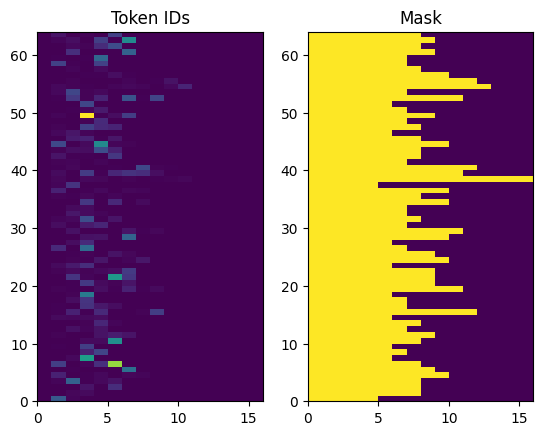

In [21]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [22]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out

In [23]:
train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [24]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[  2   5 183   9  14  23   4   3   0   0]

[ 2  7 75 11 29  4  0  0  0  0]
[ 7 75 11 29  4  3  0  0  0  0]


In [25]:
UNITS = 256

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                   mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                      # Return the sequence and state
                                      return_sequences=True,
                                      recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [34]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 14)
Encoder output, shape (batch, s, units): (64, 14, 256)


In [35]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        shape_checker = ShapeChecker()

        shape_checker(x, 'batch t units')
        shape_checker(context, 'batch s units')

        attn_output, attn_scores = self.mha(
            query=x,
            value=context,
            return_attention_scores=True)

        shape_checker(x, 'batch t units')
        shape_checker(attn_scores, 'batch heads t s')

        # Cache the attention scores for plotting later.
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        shape_checker(attn_scores, 'batch t s')
        self.last_attention_weights = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [36]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 14, 256)
Target sequence, shape (batch, t, units): (64, 14, 256)
Attention result, shape (batch, t, units): (64, 14, 256)
Attention weights, shape (batch, t, s):    (64, 14, 14)


In [38]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([0.9999999 , 1.        , 0.99999994, 1.        , 1.0000001 ,
       1.        , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ], dtype=float32)

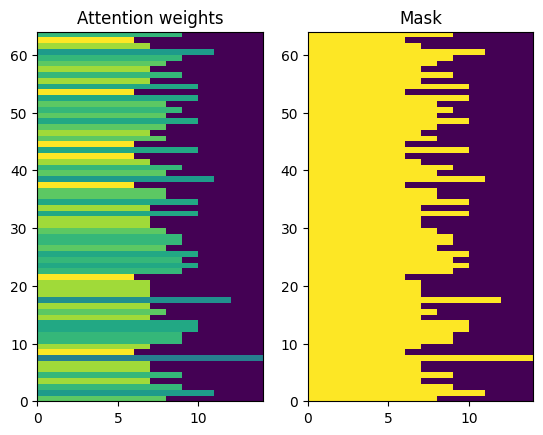

In [39]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [40]:
class Decoder(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units):
        super(Decoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                   units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        self.rnn = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttention(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [41]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch t')
    shape_checker(context, 'batch s units')

    # 1. Lookup the embeddings
    x = self.embedding(x)
    shape_checker(x, 'batch t units')

    # 2. Process the target sequence.
    x, state = self.rnn(x, initial_state=state)
    shape_checker(x, 'batch t units')

    # 3. Use the RNN output as the query for the attention over the context.
    x = self.attention(x, context)
    self.last_attention_weights = self.attention.last_attention_weights
    shape_checker(x, 'batch t units')
    shape_checker(self.last_attention_weights, 'batch t s')

    # Step 4. Generate logit predictions for the next token.
    logits = self.output_layer(x)
    shape_checker(logits, 'batch t target_vocab_size')

    if return_state:
        return logits, state
    else:
        return logits

In [42]:
decoder = Decoder(target_text_processor, UNITS)

In [43]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 14, 256)
input target tokens shape: (batch, t) (64, 14)
logits shape shape: (batch, target_vocabulary_size) (64, 14, 5000)


In [44]:
@Decoder.add_method
def get_initial_state(self, context):
    batch_size = tf.shape(context)[0]
    start_tokens = tf.fill([batch_size, 1], self.start_token)
    done = tf.zeros([batch_size, 1], dtype=tf.bool)
    embedded = self.embedding(start_tokens)
    return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [45]:
@Decoder.add_method
def tokens_to_text(self, tokens):
    words = self.id_to_word(tokens)
    result = tf.strings.reduce_join(words, axis=-1, separator=' ')
    result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
    result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
    return result

In [46]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
    logits, state = self(
        context, next_token,
        state = state,
        return_state=True) 

    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
    else:
        logits = logits[:, -1, :]/temperature
        next_token = tf.random.categorical(logits, num_samples=1)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (next_token == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

    return next_token, done, state

In [48]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)

In [56]:
for el in result[:3].numpy():
    print(el.decode("utf-8"))

пробачити родини студенти дивляться настроєний помітив пів канади біле цікаве
кращі розлучений подобалося потім голові сьогоднішню здаєшся плакатиме червні напідпитку
вимкни шпигун замовлення відчинив молодий моїми нога доларів чекатиму пихатий


In [58]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
               context_text_processor,
               target_text_processor):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(context_text_processor, units)
        decoder = Decoder(target_text_processor, units)

        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
          # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits

In [59]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 14)
Target tokens, shape: (batch, t) (64, 14)
logits, shape: (batch, t, target_vocabulary_size) (64, 14, 5000)


In [60]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [61]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [62]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [63]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [64]:
model.evaluate(val_ds, steps=20, return_dict=True)

2022-10-12 20:55:16.229699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 20:55:16.580981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 20:55:16.581075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 20:55:16.650138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 4s 88ms/step - loss: 8.5197 - masked_acc: 0.0000e+00 - masked_loss: 8.5197


{'loss': 8.519735336303711,
 'masked_acc': 0.0,
 'masked_loss': 8.519735336303711}

In [65]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2022-10-12 20:55:39.790455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 20:55:40.459893: W tensorflow/core/common_runtime/forward_type_inference.cc:332] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	while inferring type of node 'cond_41/output/_22'
2022-10-12 20:55:40.464068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 20:55:40.464435: I tensorflow/cor

100/100 [==============================] - 21s 160ms/step - loss: 4.7808 - masked_acc: 0.3035 - masked_loss: 4.7808 - val_loss: 3.8882 - val_masked_acc: 0.4162 - val_masked_loss: 3.8882
Epoch 2/100
100/100 [==============================] - 16s 158ms/step - loss: 3.6997 - masked_acc: 0.4462 - masked_loss: 3.6997 - val_loss: 3.4813 - val_masked_acc: 0.4729 - val_masked_loss: 3.4813
Epoch 3/100
100/100 [==============================] - 15s 149ms/step - loss: 3.3445 - masked_acc: 0.4857 - masked_loss: 3.3445 - val_loss: 3.1109 - val_masked_acc: 0.5072 - val_masked_loss: 3.1109
Epoch 4/100
100/100 [==============================] - 15s 146ms/step - loss: 3.0285 - masked_acc: 0.5191 - masked_loss: 3.0285 - val_loss: 2.9174 - val_masked_acc: 0.5287 - val_masked_loss: 2.9174
Epoch 5/100
100/100 [==============================] - 14s 142ms/step - loss: 2.8184 - masked_acc: 0.5364 - masked_loss: 2.8184 - val_loss: 2.6904 - val_masked_acc: 0.5524 - val_masked_loss: 2.6904
Epoch 6/100
100/100 [=

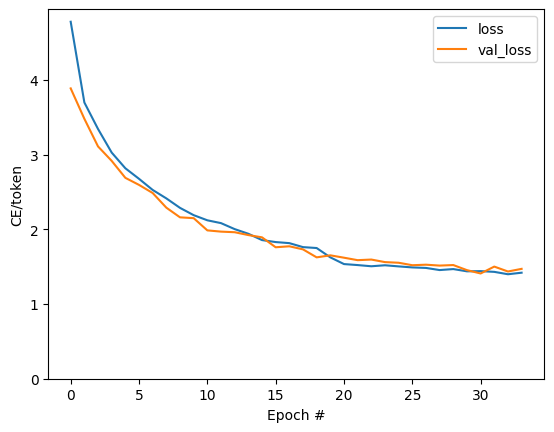

In [66]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

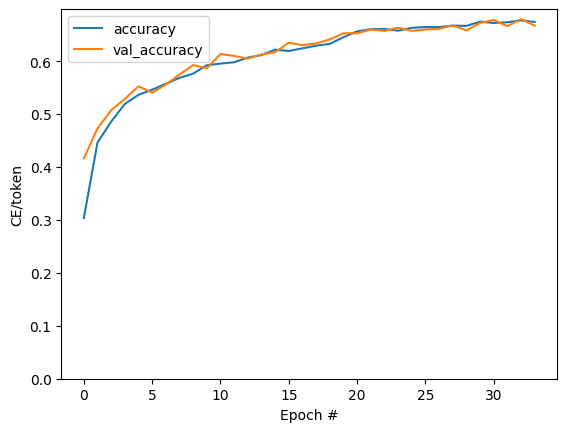

In [67]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [68]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
    # Process the input texts
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(texts)[0]

    # Setup the loop inputs
    tokens = []
    attention_weights = []
    next_token, done, state = self.decoder.get_initial_state(context)

    for _ in range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done,  state, temperature)

        # Collect the generated tokens
        tokens.append(next_token)
        attention_weights.append(self.decoder.last_attention_weights)

        if tf.executing_eagerly() and tf.reduce_all(done):
            break

    # Stack the lists of tokens and attention weights.
    tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
    self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

    result = self.decoder.tokens_to_text(tokens)
    return result

In [80]:
result = model.translate(['are you still home?'])
result[0].numpy().decode()

'ти все ще вдома ? '

In [81]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
    assert isinstance(text, str)
    output = self.translate([text], **kwargs)
    output = output[0].numpy().decode()

    attention = self.last_attention_weights[0]

    context = tf_lower_and_split_punct(text)
    context = context.numpy().decode().split()

    output = tf_lower_and_split_punct(output)
    output = output.numpy().decode().split()[1:]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + output, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')

/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


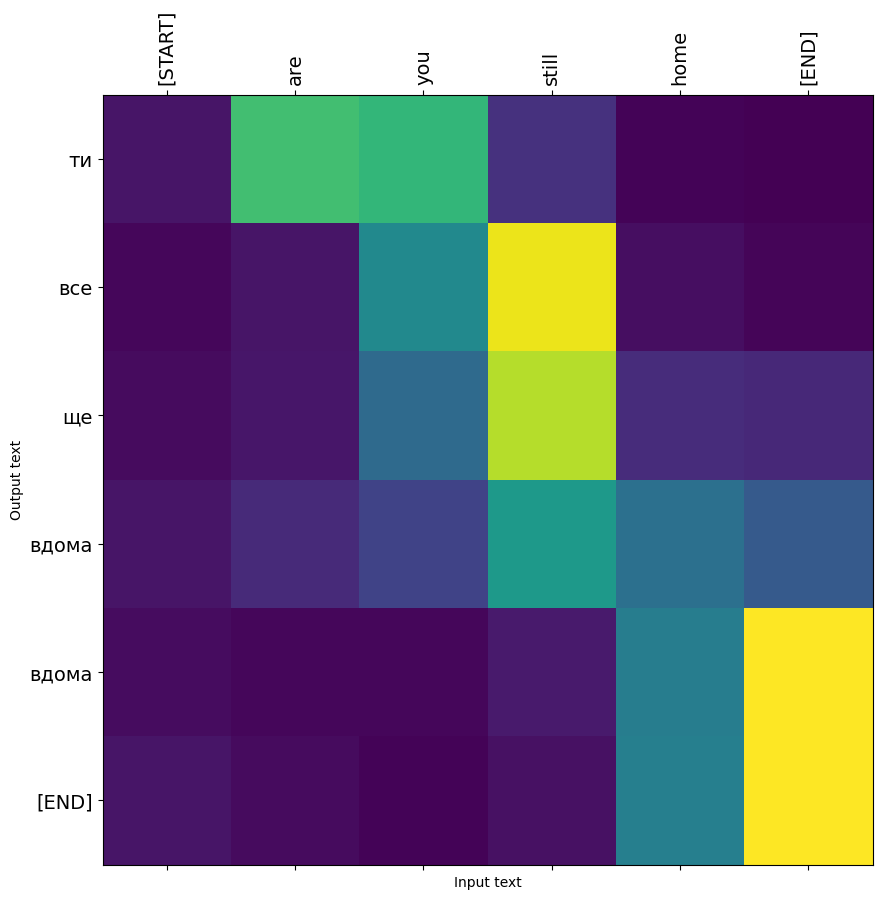

In [79]:
model.plot_attention('Are you still home'.lower())

CPU times: user 151 ms, sys: 108 ms, total: 259 ms
Wall time: 290 ms


/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


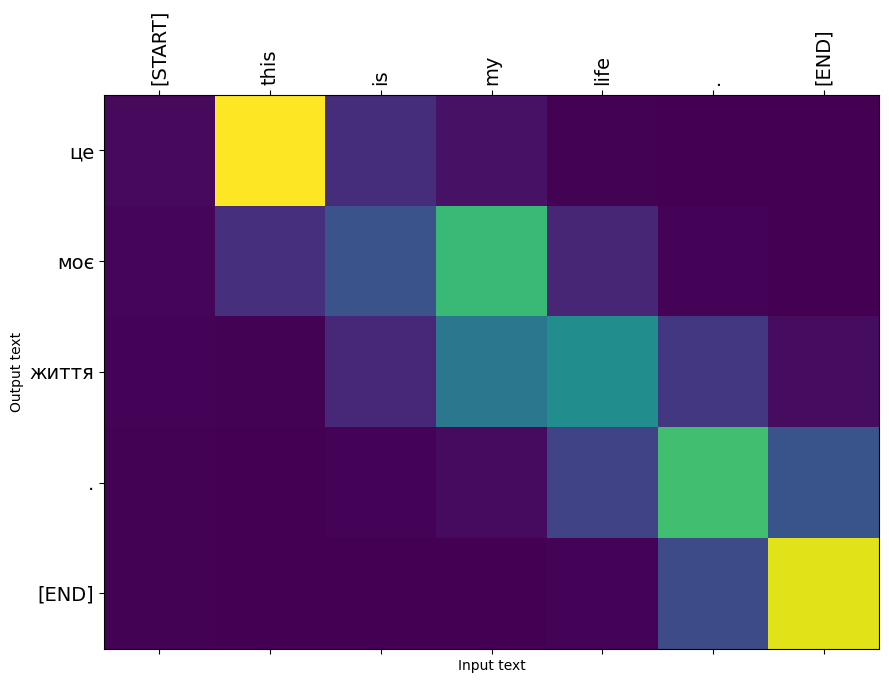

In [82]:
%%time
model.plot_attention('This is my life.')

CPU times: user 127 ms, sys: 86.2 ms, total: 213 ms
Wall time: 224 ms


/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


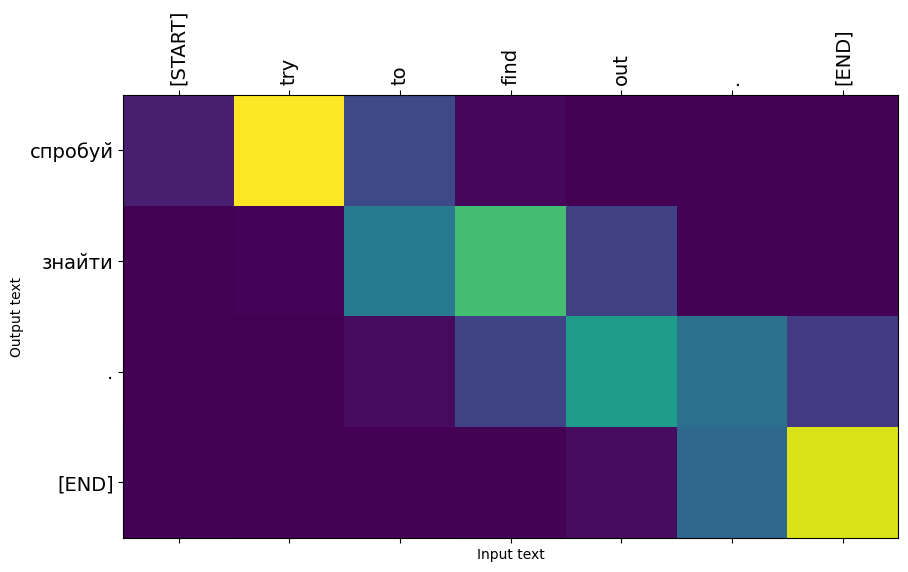

In [84]:
%%time
model.plot_attention('Try to find out.')

In [85]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 я чула, що не слід зустрічатися з кимось, кому менше половини твоїх
років плюс сім. тому зараз 30 років, а мері 17. скільки років потрібно
почекати тому, допоки він може почати зустрічатися з мері?


/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/var/folders/p3/ls8tlrt101n8mnp7jb_v1m_40000gn/T/ipykernel_22261/3440379237.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


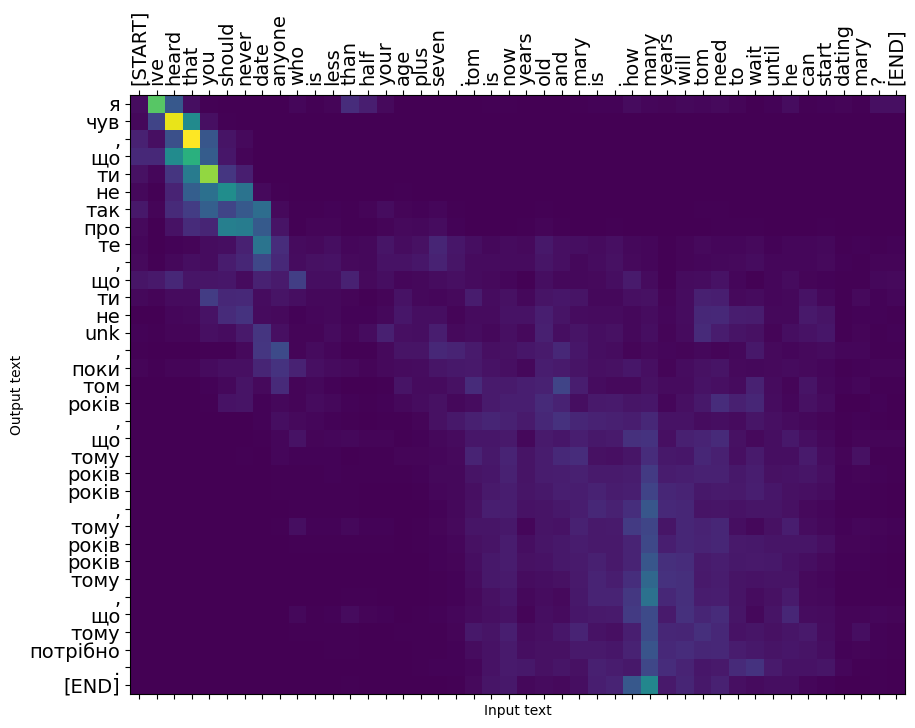

In [86]:
model.plot_attention(long_text)

In [91]:
inputs = [
    "It's really cold here", # "Тут дуже холодно."
    "This is my life.", # "Це моє життя."
    "His room is a mess." # "В його кімнаті безлад."
]

In [92]:
%%time
for t in inputs:
    print(model.translate([t])[0].numpy().decode())

print()

це дуже холодно . 
це моє життя . 
його кімната у [UNK] . 

CPU times: user 366 ms, sys: 236 ms, total: 602 ms
Wall time: 641 ms


In [93]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [94]:
export = Export(model)

In [95]:
%%time
_ = export.translate(tf.constant(inputs))

2022-10-12 21:16:51.289884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:53.178395: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-10-12 21:16:53.178945: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-10-12 21:16:53.179455: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT

2022-10-12 21:16:56.093158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:56.157046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:56.603586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:57.174131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:57.327922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:57.481464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:16:57.631635: I tensorflow/core/grappler/optimizers/cust

CPU times: user 28.4 s, sys: 2.56 s, total: 30.9 s
Wall time: 29.4 s


In [96]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

це дуже холодно .                                              
це моє життя .                                              
його кімната у [UNK] .                                             

CPU times: user 1.06 s, sys: 752 ms, total: 1.81 s
Wall time: 1.55 s


In [97]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: translator/assets


INFO:tensorflow:Assets written to: translator/assets


CPU times: user 28 s, sys: 1.45 s, total: 29.5 s
Wall time: 29.9 s


In [98]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2022-10-12 21:18:17.838577: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:18.002069: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:18.101957: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:18.201521: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:18.232319: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _ou

2022-10-12 21:18:23.374025: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:23.493435: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:23.848922: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:24.117033: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:24.148099: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _ou

2022-10-12 21:18:27.574928: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:27.581466: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:27.764499: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:27.835028: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:27.841360: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-10-12 21:18:29.462455: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:29.468823: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:29.524464: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:29.530161: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:18:29.571030: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes at

2022-10-12 21:18:41.655373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:18:41.720918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:18:41.979668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:18:42.306294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:18:42.489450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:18:42.706545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:18:42.890278: I tensorflow/core/grappler/optimizers/cust

CPU times: user 37.3 s, sys: 4.34 s, total: 41.6 s
Wall time: 38.8 s


In [99]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

це дуже холодно .                                              
це моє життя .                                              
його кімната у [UNK] .                                             

CPU times: user 1.53 s, sys: 832 ms, total: 2.36 s
Wall time: 2.02 s


In [100]:
@Translator.add_method
def translate(self,
              texts,
              *,
              max_length=500,
              temperature=tf.constant(0.0)):
    shape_checker = ShapeChecker()
    context = self.encoder.convert_input(texts)
    batch_size = tf.shape(context)[0]
    shape_checker(context, 'batch s units')

    next_token, done, state = self.decoder.get_initial_state(context)

    # initialize the accumulator
    tokens = tf.TensorArray(tf.int64, size=1, dynamic_size=True)

    for t in tf.range(max_length):
        # Generate the next token
        next_token, done, state = self.decoder.get_next_token(
            context, next_token, done, state, temperature)
        shape_checker(next_token, 'batch t1')

        # Collect the generated tokens
        tokens = tokens.write(t, next_token)

        # if all the sequences are done, break
        if tf.reduce_all(done):
            break

    # Convert the list of generated token ids to a list of strings.
    tokens = tokens.stack()
    shape_checker(tokens, 't batch t1')
    tokens = einops.rearrange(tokens, 't batch 1 -> batch t')
    shape_checker(tokens, 'batch t')

    text = self.decoder.tokens_to_text(tokens)
    shape_checker(text, 'batch')

    return text

In [101]:
%%time
result = model.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

це дуже холодно .  
це моє життя .  
його кімната у [UNK] . 

CPU times: user 242 ms, sys: 166 ms, total: 408 ms
Wall time: 596 ms


In [102]:
class Export(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def translate(self, inputs):
        return self.model.translate(inputs)

In [103]:
export = Export(model)

In [104]:
%%time
_ = export.translate(inputs)

2022-10-12 21:19:35.468481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:19:35.597532: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }
2022-10-12 21:19:35.847282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:19:35.921234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-12 21:19:36.144070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2.31 s, sys: 398 ms, total: 2.71 s
Wall time: 2.49 s


In [105]:
%%time
result = export.translate(inputs)

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

це дуже холодно .  
це моє життя .  
його кімната у [UNK] . 

CPU times: user 163 ms, sys: 125 ms, total: 287 ms
Wall time: 195 ms


In [106]:
%%time
tf.saved_model.save(export, 'dynamic_translator',
                    signatures={'serving_default': export.translate})

INFO:tensorflow:Assets written to: dynamic_translator/assets


INFO:tensorflow:Assets written to: dynamic_translator/assets


CPU times: user 12 s, sys: 1.17 s, total: 13.2 s
Wall time: 13.6 s


In [107]:
%%time
reloaded = tf.saved_model.load('dynamic_translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup

2022-10-12 21:20:07.654153: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:07.660570: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:07.670217: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:07.676018: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:07.848168: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_sh

2022-10-12 21:20:10.434092: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:10.440251: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:10.639379: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:10.645929: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 48 outputs. Output shapes may be inaccurate.
2022-10-12 21:20:10.682820: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 14 outputs but the _output_sh

CPU times: user 6.66 s, sys: 1.55 s, total: 8.2 s
Wall time: 8.43 s


In [108]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

це дуже холодно .  
це моє життя .  
його кімната у [UNK] . 

CPU times: user 147 ms, sys: 96.5 ms, total: 243 ms
Wall time: 160 ms
